In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

# Collect the data for the google stock 

In [4]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 1, 1)
x = web.DataReader("F", 'google', start, end)
x.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,13.87,14.00,13.75,13.97,38525811
2016-01-05,13.97,14.00,13.51,13.72,50267536
2016-01-06,13.56,13.56,13.05,13.11,61285453
2016-01-07,12.90,13.04,12.60,12.70,57846688
2016-01-08,13.05,13.10,12.50,12.54,46199413


In [5]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 5 columns):
Open      252 non-null float64
High      252 non-null float64
Low       252 non-null float64
Close     252 non-null float64
Volume    252 non-null int64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


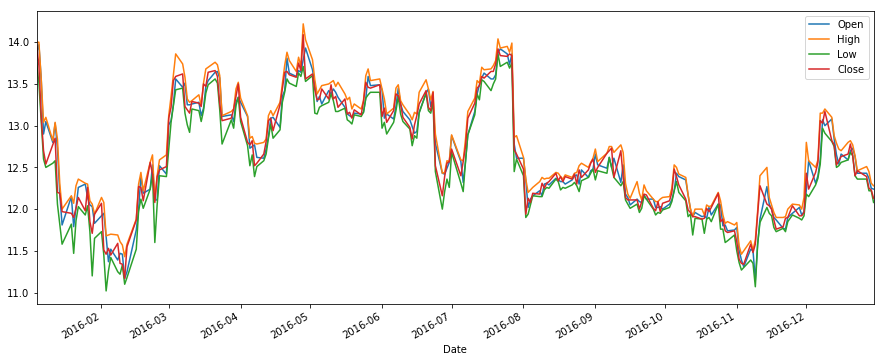

In [6]:
x.drop("Volume", axis=1).plot(figsize=(15, 6))
plt.show()

So, we loaded the google stock for one year. Now, we want to predict the High column.

# Create forecasting frame

In [7]:
df_shift, y = make_forecasting_frame(x["High"], kind="price", max_timeshift=10, rolling_direction=1)

In [8]:
df_shift.head()

,time,value,id,kind
2214,2016-01-04,14.0,2016-01-05,price
1964,2016-01-04,14.0,2016-01-06,price
2215,2016-01-05,14.0,2016-01-06,price
1715,2016-01-04,14.0,2016-01-07,price
1965,2016-01-05,14.0,2016-01-07,price


`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [10]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|██████████| 251/251 [00:08<00:00, 28.94it/s]


In [11]:
X.head()

variable,feature__abs_energy,feature__absolute_sum_of_changes,"feature__agg_autocorrelation__f_agg_""mean""","feature__agg_autocorrelation__f_agg_""median""","feature__agg_autocorrelation__f_agg_""var""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,feature__time_reversal_asymmetry_statistic__lag_1,feature__time_reversal_asymmetry_statistic__lag_2,feature__time_reversal_asymmetry_statistic__lag_3,feature__value_count__value_-inf,feature__value_count__value_0,feature__value_count__value_1,feature__value_count__value_inf,feature__value_count__value_nan,feature__variance,feature__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2016-01-05,196.0000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2016-01-06,392.0000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2016-01-07,575.8736,0.44,-0.625000,-0.625000,0.140625,0.0,0.0,0.0,0.0,0.0,...,-169.769600,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.043022,0.0
2016-01-08,745.9152,0.96,-0.612853,-0.783749,0.483390,0.0,0.0,0.0,0.0,0.0,...,-260.882752,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.156300,0.0
2016-01-11,917.5252,1.02,-0.558454,-0.804121,0.562130,0.0,0.0,0.0,0.0,0.0,...,-227.227616,-330.7284,0.0,0.0,0.0,0.0,0.0,0.0,0.173440,0.0


#  Fit Adaboost

In [12]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :])
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [13]:
y_pred = pd.Series(data=y_pred, index=y.index)

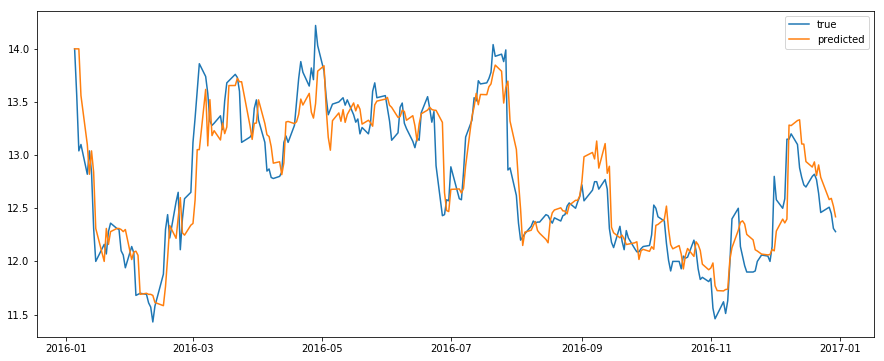

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

Looks not to bad. The green curve is the output of the AdaBoost Regressor, the blue curve is the true High value.

We can also inspect the relevance of the extracted features

In [15]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False)

variable
feature__maximum                                                        0.206668
feature__minimum                                                        0.129076
feature__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0    0.080266
feature__quantile__q_0.1                                                0.078104
feature__quantile__q_0.7                                                0.062624
feature__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0    0.043311
feature__approximate_entropy__m_2__r_0.9                                0.030982
feature__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2    0.030705
feature__first_location_of_minimum                                      0.025847
feature__quantile__q_0.2                                                0.025284
feature__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0      0.024997
feature__quantile__q_0.8                                                0.021383
feature__quantile__

So, the minumum value "feature__maximum" during the last 10 values had the highest importance to predict next value of High column